<a href="https://colab.research.google.com/github/deujahritik/AI__12194824/blob/main/Week_11_lab_session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
# Save datagenerators as file to colab working directory
# If you are using GitHub, make sure you get the "Raw" version of the code
url = 'https://raw.githubusercontent.com/NVDLI/LDL/main/pt_framework/utilities.py'
r = requests.get(url)
# make sure your filename is the same as how you want to import
with open('utilities.py','w') as f:
  f.write(r.text)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utilities import train_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 100
BATCH_SIZE = 16

TRAIN_TEST_SPLIT = 0.8
MIN = 12
FILE_NAME = '/content/book_store_sales.csv'

def readfile(file_name):
    file = open(file_name, 'r', encoding='utf-8')
    next(file)
    data = []
    for line in (file):
        values = line.split(',')
        data.append(float(values[1]))
    file.close()
    return np.array(data, dtype=np.float32)

# Read data and split up into train and test data.
sales = readfile(FILE_NAME)
months = len(sales)
split = int(months * TRAIN_TEST_SPLIT)
train_sales = sales[0:split]
test_sales = sales[split:]

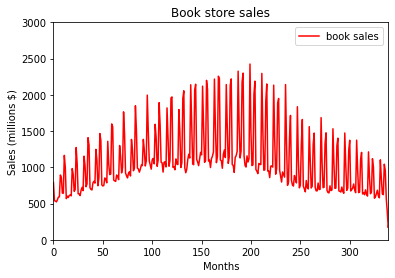

In [ ]:
# Plot dataset
x = range(len(sales))
plt.plot(x, sales, 'r-', label='book sales')
plt.title('Book store sales')
plt.axis([0, 339, 0.0, 3000.0])
plt.xlabel('Months')
plt.ylabel('Sales (millions $)')
plt.legend()
plt.show()

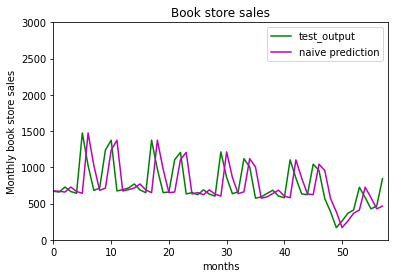

In [ ]:
# Plot naive prediction
test_output = test_sales[MIN:]
naive_prediction = test_sales[MIN-1:-1]
x = range(len(test_output))
plt.plot(x, test_output, 'g-', label='test_output')
plt.plot(x, naive_prediction, 'm-', label='naive prediction')
plt.title('Book store sales')
plt.axis([0, len(test_output), 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Monthly book store sales')
plt.legend()
plt.show()

In [ ]:
# Standardize train and test data.
# Use only training seasons to compute mean and stddev.
mean = np.mean(train_sales)
stddev = np.std(train_sales)
train_sales_std = (train_sales - mean)/stddev
test_sales_std = (test_sales - mean)/stddev

In [ ]:
# Create train examples.
train_months = len(train_sales)
train_X = np.zeros((train_months-MIN, train_months-1, 1), dtype=np.float32)
train_y = np.zeros((train_months-MIN, 1), dtype=np.float32)
for i in range(0, train_months-MIN):
    train_X[i, -(i+MIN):, 0] = train_sales_std[0:i+MIN]
    train_y[i, 0] = train_sales_std[i+MIN]

# Create test examples.
test_months = len(test_sales)
test_X = np.zeros((test_months-MIN, test_months-1, 1), dtype=np.float32)
test_y = np.zeros((test_months-MIN, 1), dtype=np.float32)
for i in range(0, test_months-MIN):
    test_X[i, -(i+MIN):, 0] = test_sales_std[0:i+MIN]
    test_y[i, 0] = test_sales_std[i+MIN]

# Create Dataset objects.
trainset = TensorDataset(torch.from_numpy(train_X).clone(), torch.from_numpy(train_y))
testset = TensorDataset(torch.from_numpy(test_X).clone(), torch.from_numpy(test_y))

In [ ]:
# Custom layer that retrieves only last time step from RNN output.
class LastTimestep(nn.Module):
    def forward(self, inputs):
        return inputs[1][0]

# Create RNN model
model = nn.Sequential(
    nn.RNN(1, 128, nonlinearity='relu', batch_first=True),
    LastTimestep(),
    nn.Linear(128, 1)
)

# Loss function and optimizer.
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.MSELoss()

# Train model.
train_model(model, device, EPOCHS, BATCH_SIZE, trainset, testset,
            optimizer, loss_function, 'mae')

Epoch 1/100 loss: 0.9383 - mae: 0.7503 - val_loss: 1.1671 - val_mae: 0.8434
Epoch 2/100 loss: 0.8156 - mae: 0.6529 - val_loss: 0.8913 - val_mae: 0.7388
Epoch 3/100 loss: 0.5981 - mae: 0.5859 - val_loss: 0.6174 - val_mae: 0.5952
Epoch 4/100 loss: 0.4970 - mae: 0.5152 - val_loss: 0.4283 - val_mae: 0.4953
Epoch 5/100 loss: 0.4783 - mae: 0.5042 - val_loss: 0.2418 - val_mae: 0.3149
Epoch 6/100 loss: 0.4474 - mae: 0.5048 - val_loss: 0.2856 - val_mae: 0.3973
Epoch 7/100 loss: 0.4227 - mae: 0.4999 - val_loss: 0.5258 - val_mae: 0.5392
Epoch 8/100 loss: 0.4839 - mae: 0.5317 - val_loss: 0.2939 - val_mae: 0.4106
Epoch 9/100 loss: 0.5501 - mae: 0.5169 - val_loss: 0.4493 - val_mae: 0.5340
Epoch 10/100 loss: 0.4022 - mae: 0.4691 - val_loss: 0.2453 - val_mae: 0.2985
Epoch 11/100 loss: 0.3452 - mae: 0.4368 - val_loss: 0.2082 - val_mae: 0.2842
Epoch 12/100 loss: 0.2996 - mae: 0.4075 - val_loss: 0.3017 - val_mae: 0.3635
Epoch 13/100 loss: 0.2556 - mae: 0.3721 - val_loss: 0.2230 - val_mae: 0.2785
Epoch 14

[0.09091299333993126, 0.11754252575337887]

In [ ]:
# Create naive prediction based on standardized data.
test_output = test_sales_std[MIN:]
naive_prediction = test_sales_std[MIN-1:-1]
mean_squared_error = np.mean(np.square(naive_prediction
                                       - test_output))
mean_abs_error = np.mean(np.abs(naive_prediction
                                - test_output))
print('naive test mse: ', mean_squared_error)
print('naive test mean abs: ', mean_abs_error)

naive test mse:  0.4723033
naive test mean abs:  0.48052385


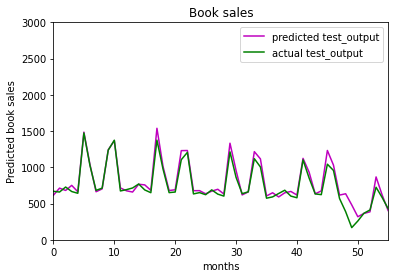

In [ ]:
# Use trained model to predict the test data
inputs = torch.from_numpy(test_X)
inputs = inputs.to(device)
outputs = model(inputs)
predicted_test = outputs.cpu().detach().numpy()

# De-standardize output.
predicted_test = np.reshape(predicted_test,
                            (len(predicted_test)))
predicted_test = predicted_test * stddev + mean

# Plot test prediction.
x = range(len(test_sales)-MIN)
plt.plot(x, predicted_test, 'm-',
         label='predicted test_output')
plt.plot(x, test_sales[-(len(test_sales)-MIN):],
         'g-', label='actual test_output')
plt.title('Book sales')
plt.axis([0, 55, 0.0, 3000.0])
plt.xlabel('months')
plt.ylabel('Predicted book sales')
plt.legend()
plt.show()